<h3>MNIST</h3>

This is a dataset constains 70,000 small images of digits handwrittenbyb high school students and employees fo the US Cnesus Bureau.

Scikit-Learn provides many helper functions to download popular datasets. 
The new `fetch_openml` are not sorted,so we are sorting the dataset with the below funtion

In [1]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
#mnist["data"], mnist["target"]

The DataSet consists of 
* `DESCR` which is the description of dataset
* `data` key which containing an array with one row per instance and one column per feature 
* `target` key containing an array with the labels

In [4]:
# look at the shapes of the arrays 

X,y = mnist["data"] , mnist["target"]

X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

Analysis if the shape of X(input) : 
There are 70,000 images and each images has 784 features. This is because each image is 28X28 pixels,and each feature represent one pixel's intensity (0-255).  

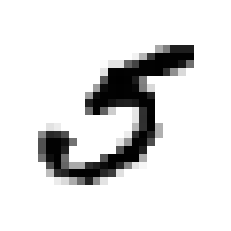

In [6]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28) # reshape it into a 28X28 array. 

plt.imshow(some_digit_image, cmap =matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show() # the image show a 9 

In [7]:
y[36000] # the label also gave us 9

5

<h3>Split the data</h3>

We should always create a test set for our data but this dataset is actually already split into a training set (first 60,000) and test set(last 10,000).

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We also want to shuffle our data, this will guarantee that all cross_validaion folds will be similar.Also some ML algorithms are sensitive to the order of the training instances, and they perform poorly if they get similar instances in a row. 

In [9]:
import numpy as np 

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


<h3>Training a Binary Classifier</h3>

It is capable of distinguishing between just 2 classes, 5 and not-5. 

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


A good place to start is with *Stochastic Gradient Descent (SGD)* classifier. This classifier has the advantage of capable of handling  very large dataset efficiently. 

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

<h3>Performance Measures</h3>

Evaluating a classifier is trickier than evaluating a regressor. 
1. Measuring Accuracy Using Cross-Validation 
2. Confussion Matrix 
3. Precision and Recall 
4. The ROC curve

In [13]:
# Implementing Cross Validation yourself instead of using cross_val_score()

from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index , test_index in skfolds.split(X_train, y_train_5):
    # create a clone of the classifier 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    # train the clone on the training folds 
    clone_clf.fit(X_train_folds,y_train_folds)
    # makes prediction on the test fold
    y_pred = clone_clf.predict(X_test_fold)
    # counts the number of correct predictions 
    n_correct= sum(y_pred == y_test_fold)
    # output the ratio of correct predictions
    print(n_correct/len(y_pred))

/Users/kaixuanchin/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.9672
0.9562
0.9606


In [14]:
# we are using the cross_val_score to evaluate the sgd classifier 

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5 , cv=3 , scoring="accuracy")

array([0.9672, 0.9562, 0.9606])

In [15]:
# dumb classifier that classify image in the "not-5" class
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5 , cv= 3 , scoring="accuracy")

array([0.91135, 0.91175, 0.90585])

Both of them are more than 90% accuracy. This is because only 10% of the images are 5s, and 90% is not 5, so the classifier is 90% right all the time. 
This show that accuracy is not the best way to deal with skewed dataset. 

<h5>2. Confusion Matrix</h5>

The general Idea: 
    count the number of times instances of Class A are classified as class B. 
    
To compute the confusion matrix, we need to have a set of predictions, so that they can be compared to the actual targets. 

In [17]:
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)


`cross_val_predict()` performs K-fold  cross-validation, but instead of returing the evaluation scores, it returns the predictions made on each test fold. 

This means that we can get a "clean" prediction each time (the prediction is made by a model that never saw the data during training) 

In [18]:
from sklearn.metrics import confusion_matrix 

confusion_matrix(y_train_5, y_train_pred)

array([[54193,   386],
       [ 1934,  3487]])

Each row is the actual class and each column is the predicted class. 

The first row where consider non-5 images: 53967 where correctly classified as non-5s (True negative) 
The first row and second column is wrongly classified 5 images: 612 (False Positives) 

The second row consider the 5 images: 1682 wrongly classified as non-5 (false negatives)
The second row second column : 3739 correctly classified as 5s (true positive)

Perfect classifier only have true positive and true negatives


In [19]:
#confusion_matrix(y_train_5 , y_train_perfect_predictions)

Precision = accuracy of the positive predictions

$$
precision = \frac{TP}{TP+TF}
$$ 

TP is the number of true positives, FP is the number of false positives

One trivial way to have perfect precision is to make one single positive prediction and ensure it is correct. This will not be really useful since the classifier would ignore all but one positive instance. So it is usually used with another matric named *recall* also called as *sensitiviy* or *true positive rate*

$$
Recall = \frac{TP}{TP + FN}
$$

FN is the number of false negative

 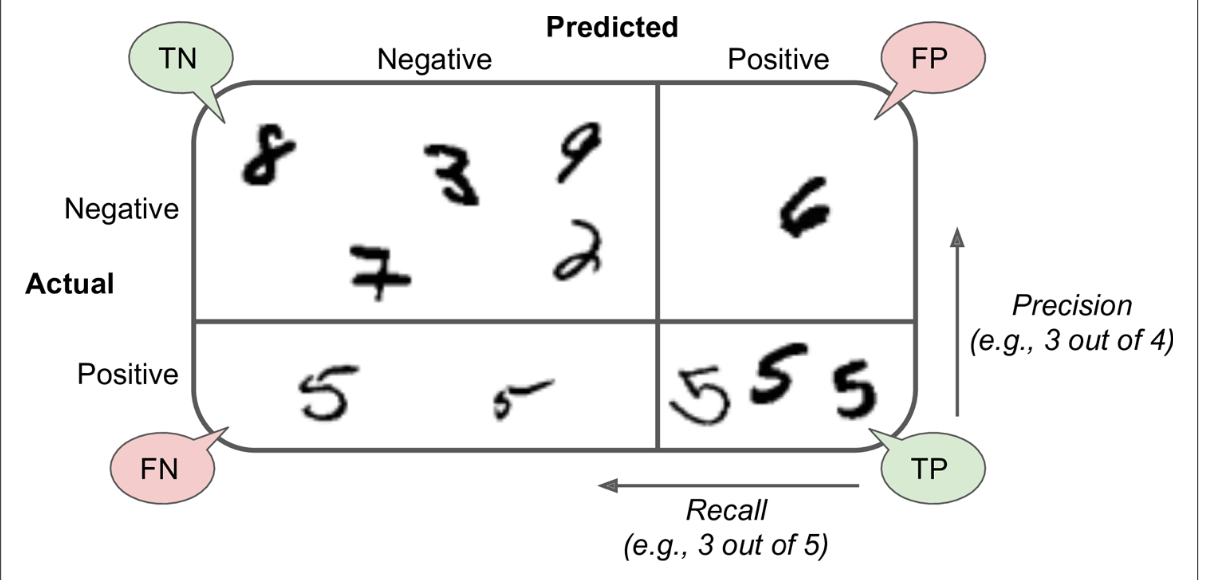

<h5>3. Precision and Recall</h5>

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.9003356571133488

In [21]:
recall_score(y_train_5, y_train_pred)

0.6432392547500461

When your model claim an image represents a 5, it is correctly only 86% of the time and it also detected 69% of the 5s 

Usually we use $F_1$ score which is the harmonic mean of precision and recall. $F_1$ score is high when both recall and precision are high

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision*recall}{precision+recall} = \frac{TP}{TP + \frac{FN+FP}{2}}
$$

In [22]:
from sklearn.metrics import f1_score 

f1_score(y_train_5,y_train_pred)

0.7503765870454056

**Precision/Recall Tradeoff**

$F_1$ score favors classifirs that have similar precision and recall. This is not always what you want.

Example on only care about precision: classifier to detect videos that are safe for the kids. A classifier that rejects many good vidoes (low recall) but keeps only safe one(high precision)

Example on only care about recall : classifier to detect shoplifters on surveillance images

We cannot have both.
> Increasing Precision reduces recall, and vice versa 

Classifier computes a score based on a *decision function* , if the score is greater than treshold, it asigns the instance to the positive class or else it assigns ut to a neg class. 

if The decision threshold is in the center, 4 will be true positive(actual 5) on the right of the threshol and one false positive (actually a 6)

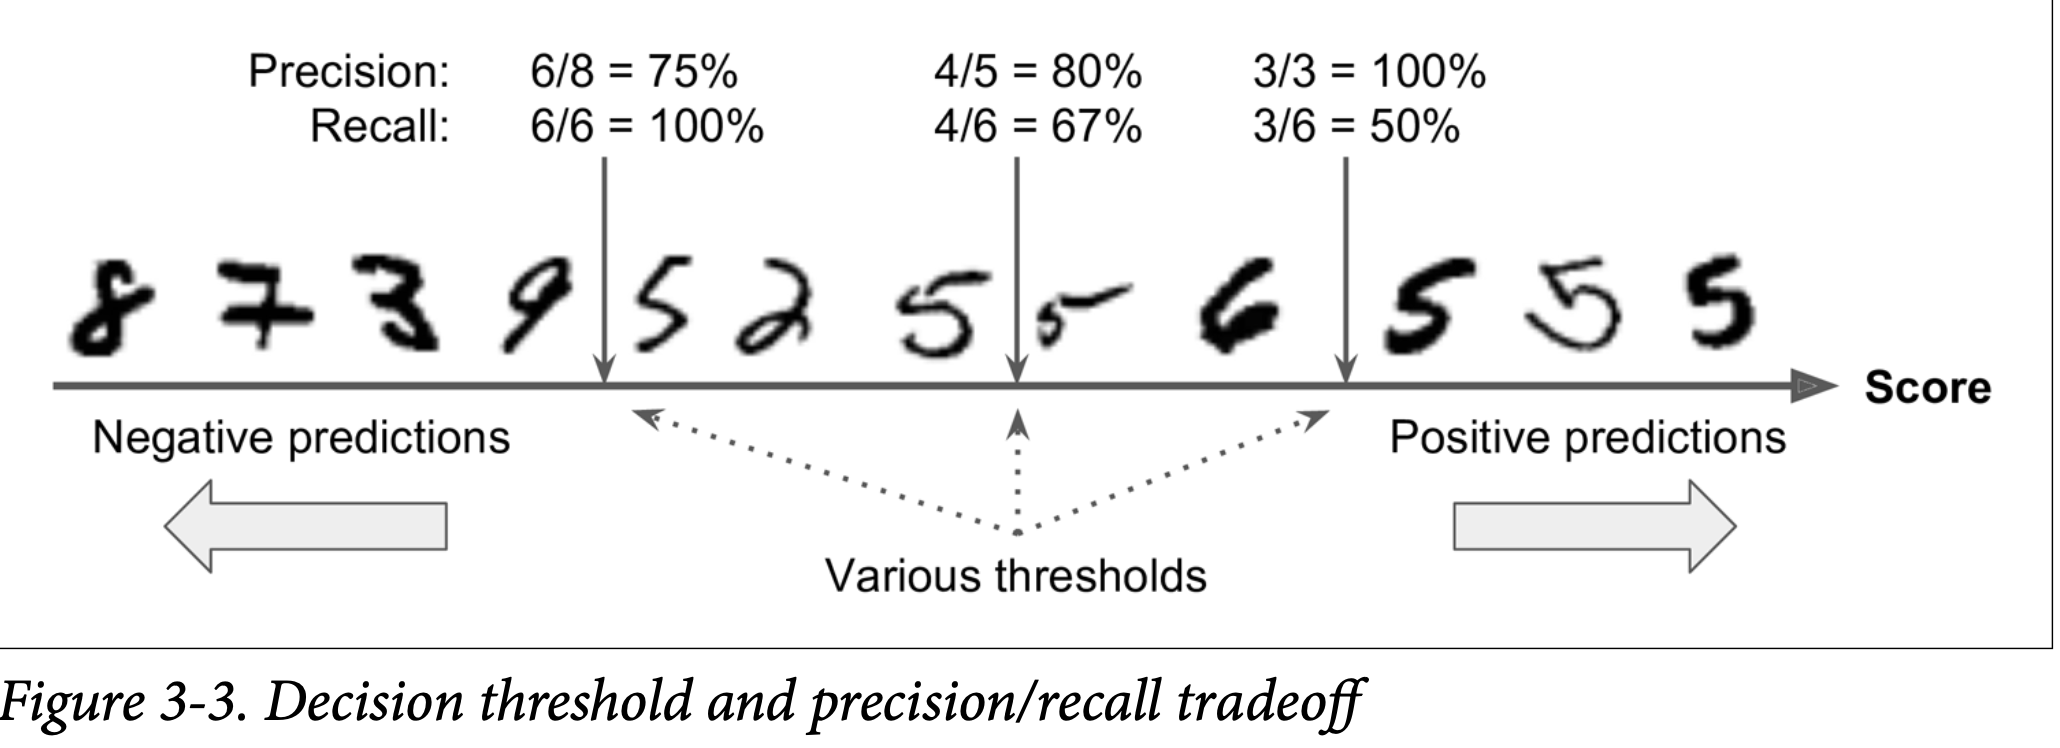


In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([101747.56992984])

In [24]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 400000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The above proved that raising threshold decreases recall. How do you decide which threshold to use? 

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5 , cv= 3 , method="decision_function") # specify what you want to return which is decision scores 

In [27]:
from sklearn.metrics import precision_recall_curve 

# precision_recall_curve to get all the values from the predict 
precisions, recalls, thresholds = precision_recall_curve(y_train_5 , y_scores)



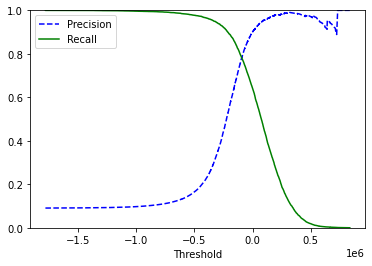

In [28]:
# use a matplotlib 

def plot_precision_recall_vs_threshold (precisions, recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],"b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-" , label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Why precision curve is bumpier than the recall curve?

The reason is that precision may sometimes go down when you raise the threshold. Recall can only go down when the threshold is increased which explain its cruve looks smooth

Now we can simply select the threshold value that gives you the best precision/recall tradeoff. 

Another good wat to select a good precision/recall tradeoff is to plot precision directly against recall. 

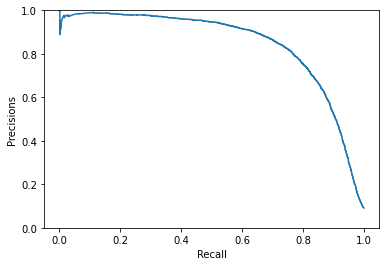

In [29]:
# plot precision vs recall 

def plot_precision_vs_recall(precisions , recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precisions")
    plt.ylim([0,1])
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

You can see that precision starts to fall sharply around 80% recall. better to select a precision/recall tradeoff just before that drop which is 60% recall, but it also depends on your project. 

Suppose that you take 90% precision, the threshold of about 70,000. To make predictions(on the training set for now), instead of calling the classifiers's `predict()` method, we can do bellow

In [30]:
y_train_pred_90 = (y_scores > 70000)

In [31]:
precision_score (y_train_5, y_train_pred_90)


0.9450886766712142

In [32]:
recall_score(y_train_5,y_train_pred_90)

0.511160302527209

When we said that we have 90% precision, we probably have a lower recall rate. 

<h5>4. The ROC Curve</h5>

It is similar to precision/recall curve, but instead of ploting precision versus recall, the ROC curve plots the true positive rate( another name for recall) against the false positive rate. 

The False positive rate(FPR) is the ratio of negative instances that are incorrectly classified as positive. 
FPR = 1 - TNR

The True Negative Rate(TNR) is also call specificity. 

Hence, ROC curve plots sensitivity vs 1-specificity

In [33]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)


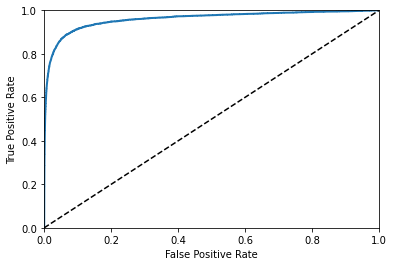

In [34]:
def plot_roc_curve(fpr, tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2 , label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

There is still a tradeoff: 
> The higher the recall(TPR), the more false postitives (FPR) the classifier produces. 

The dotted line represent the ROC curve of a purely random classifier, a good classifier stays as far away from that line as possible(toward the top-left corner) 

One way to compare classifier, is to find the *area under the curve*. If the *AUC* is equals to 1, that means it is perfect. The random classifier has *AUC* of 0.5

In [35]:
from sklearn.metrics import roc_auc_score 

roc_auc_score(y_train_5,y_scores)


0.9603606427315601

**When should we use ROC or PR?**

We should consider PR is the positive class is rare or when you care more about the false positives than the false negative.

ROC if you are about false negative rather than false positive.

In [36]:
# use a random forect classifier and compare the ROC 

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest= cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

# predict ROC, we need scores not probabilities 

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

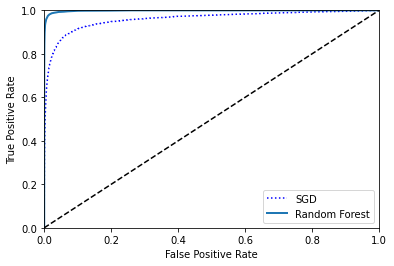

In [37]:
plt.plot(fpr,tpr,"b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

A RandomForestClassifier's ROC curve looks much better than the SGDClassifier's

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984465501266373

<h3>Multiclass Classification</h3>

Some algorithms(such as Random Forest Classifiers or naive Bayes Classifier) are capable of handling multiple class directly. Others ( Such as SVM classifiers or Linear Classifier) are strickly binary classifiers. 

<h5>One-versus-all strategy</h5>

For example, one way to create a system that can classify the digit images into 10 classes is to train 10 binary classifiers, once for each digit. Then when you want to classify an image, you get the secidiion score from each classifier for that image and you select the class whose classifier outputs the highest score. 


<h5>One-versus-one strategy</h5>

Train a binary classifier for every pair of digits: one to distingush 0s and 1s , another distinguish 0s and 2s and so on. If there are N classes, we need to train N X (N-1) /2 classifier. 

In [39]:
sgd_clf.fit(X_train,y_train) 
sgd_clf.predict([some_digit])

array([3], dtype=int8)

Under the hood, scikit-learn trained 10 binary classifiers, git their decision scores for the images and selected the class with the highest score. 

In [40]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-251471.40192586, -585746.5844641 , -320609.25140698,
         -58972.05032167, -417847.96150327, -107255.62517566,
        -760854.7415029 , -232267.18860153, -660418.06622495,
        -724488.18540665]])

In [41]:
np.argmax(some_digit_scores)

3

In [42]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [43]:
sgd_clf.classes_[5]

5

If you would like to force Scikit-learn ro use OVO or OVA, we can use `OneVsOneClassifier` or `OneVsRestClassifier`

In [44]:
from sklearn.multiclass import OneVsOneClassifier 

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

ovo_clf.predict([some_digit])


array([5], dtype=int8)

In [45]:
len(ovo_clf.estimators_)

45

`RandomForestClassifier` can directly classify instances into multiple classes. We can call `predict_proba()` to get the list of probabilities that the classifier assigned to each instances for each class

In [46]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [47]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.11, 0.  , 0.84, 0.02, 0.01, 0.01, 0.01]])

In [48]:
# using cross validation to evaluate classifiers 
cross_val_score(sgd_clf,X_train,y_train,cv=3 , scoring="accuracy")

array([0.88185, 0.88295, 0.84765])

In [49]:
# we can use a standard scaler to improve the accuracy of the classifier

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled,y_train,cv=3, scoring="accuracy")

array([0.9104 , 0.90965, 0.9121 ])

<h3>Error Analysis</h3>

In this case, we assume that we found our model and we want to find ways to improve it. We can try looking at our errors. 


In [50]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5735,    2,   20,    9,   13,   47,   44,    7,   42,    4],
       [   2, 6483,   48,   28,    6,   36,    8,   12,  105,   14],
       [  54,   45, 5316,  108,   83,   24,   94,   53,  168,   13],
       [  49,   43,  131, 5325,    2,  253,   34,   56,  143,   95],
       [  18,   28,   29,    8, 5393,    8,   54,   25,   78,  201],
       [  68,   46,   27,  170,   73, 4650,  108,   27,  160,   92],
       [  29,   27,   43,    3,   47,   94, 5625,    5,   45,    0],
       [  23,   20,   72,   28,   61,   11,    7, 5798,   15,  230],
       [  45,  162,   66,  153,   14,  164,   55,   21, 5042,  129],
       [  40,   33,   26,   86,  174,   36,    2,  193,   83, 5276]])

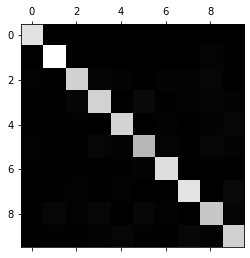

In [51]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

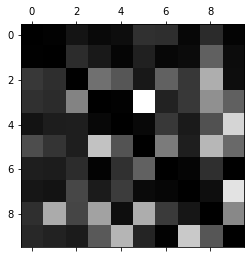

In [52]:
# we need to plot the errors

row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx= conf_mx / row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

The row is the actual class and the column is the predicted class. 

The **columns of 8 and 9** are quite bright compare to the others, which tells you that many images get misclassified as 8s or 9s. 

The **row 8 and 9** is quite bright compare to others, which tell you that it often confused with other digit

Looking at the error, we can get insights on ways to improve our classifier. Based on trhe plot, we should be spent on improving classififcation of 8s and 9s as well as fixing the specific 3/5 confusion. We can try tp gather more training data for these digits

In [53]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

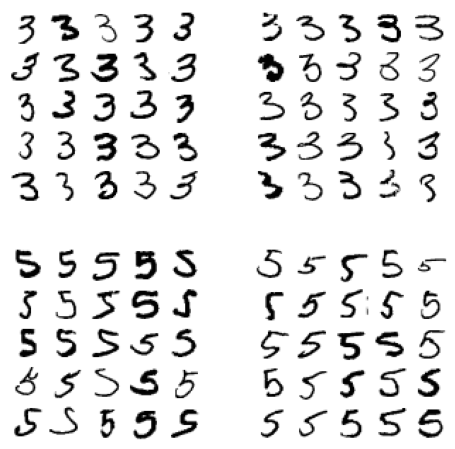

In [54]:
# analyzing individual errors but time consuming

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

<h3>Mulitlabel Classification</h3>



In [55]:
from sklearn.neighbors import KNeighborsClassifier 

y_train_large =(y_train >= 7)
y_train_odd = (y_train % 2 == 1 )
y_multilabel = np.c_[y_train_large,y_train_odd] # return 2 class which is larger than 7 or is it an odd number

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [56]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [57]:
# # f1 score (this may take a long time) 

# y_train_knn_pred = cross_val_predict(knn_clf, X_train , y_train, cv=3)
# f1_score(y_train,y_train_knn_pred,average="macro")

<h3>Mulitoutput Classification</h3>

a generalization of multilabel classification where each label can be multiclass

For example, removes noise from images. 

In [59]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

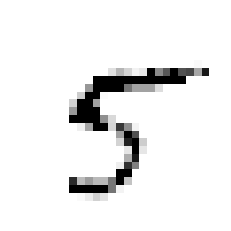

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)